In [1]:
import numpy as np
import matplotlib.pyplot as plt
from load import load_daily_generation_data

# Linear Regression

In [148]:
input_file = '.\Data\gen_by_fuel.csv'
data = load_daily_generation_data(input_file)
day_of_week = np.array([ts.weekday() for ts in data['timestamps']])
day_of_month = np.array([ts.day - 1 for ts in data['timestamps']])
month = np.array([ts.month - 1 for ts in data['timestamps']])

def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

day_of_week_1h = get_one_hot(day_of_week, 7)
day_of_month_1h = get_one_hot(day_of_month, 31)
month_1h = get_one_hot(month, 12)

X_1h = np.concatenate((day_of_week_1h, day_of_month_1h, month_1h), axis=1)

[400361.70000000007, 414680.50000000006, 490428.8, 531699.2000000001, 564399.9, 576347.4999999999, 595178.1, 569969.8, 552886.1000000001, 633039.0000000002]


Score for total: 0.7534328058396861
Score for renewables: 0.2729333071818876
Score for non_renewables: 0.7569385179157351
Score for wind: 0.3308122256784941
Score for coal: 0.7870382005492849


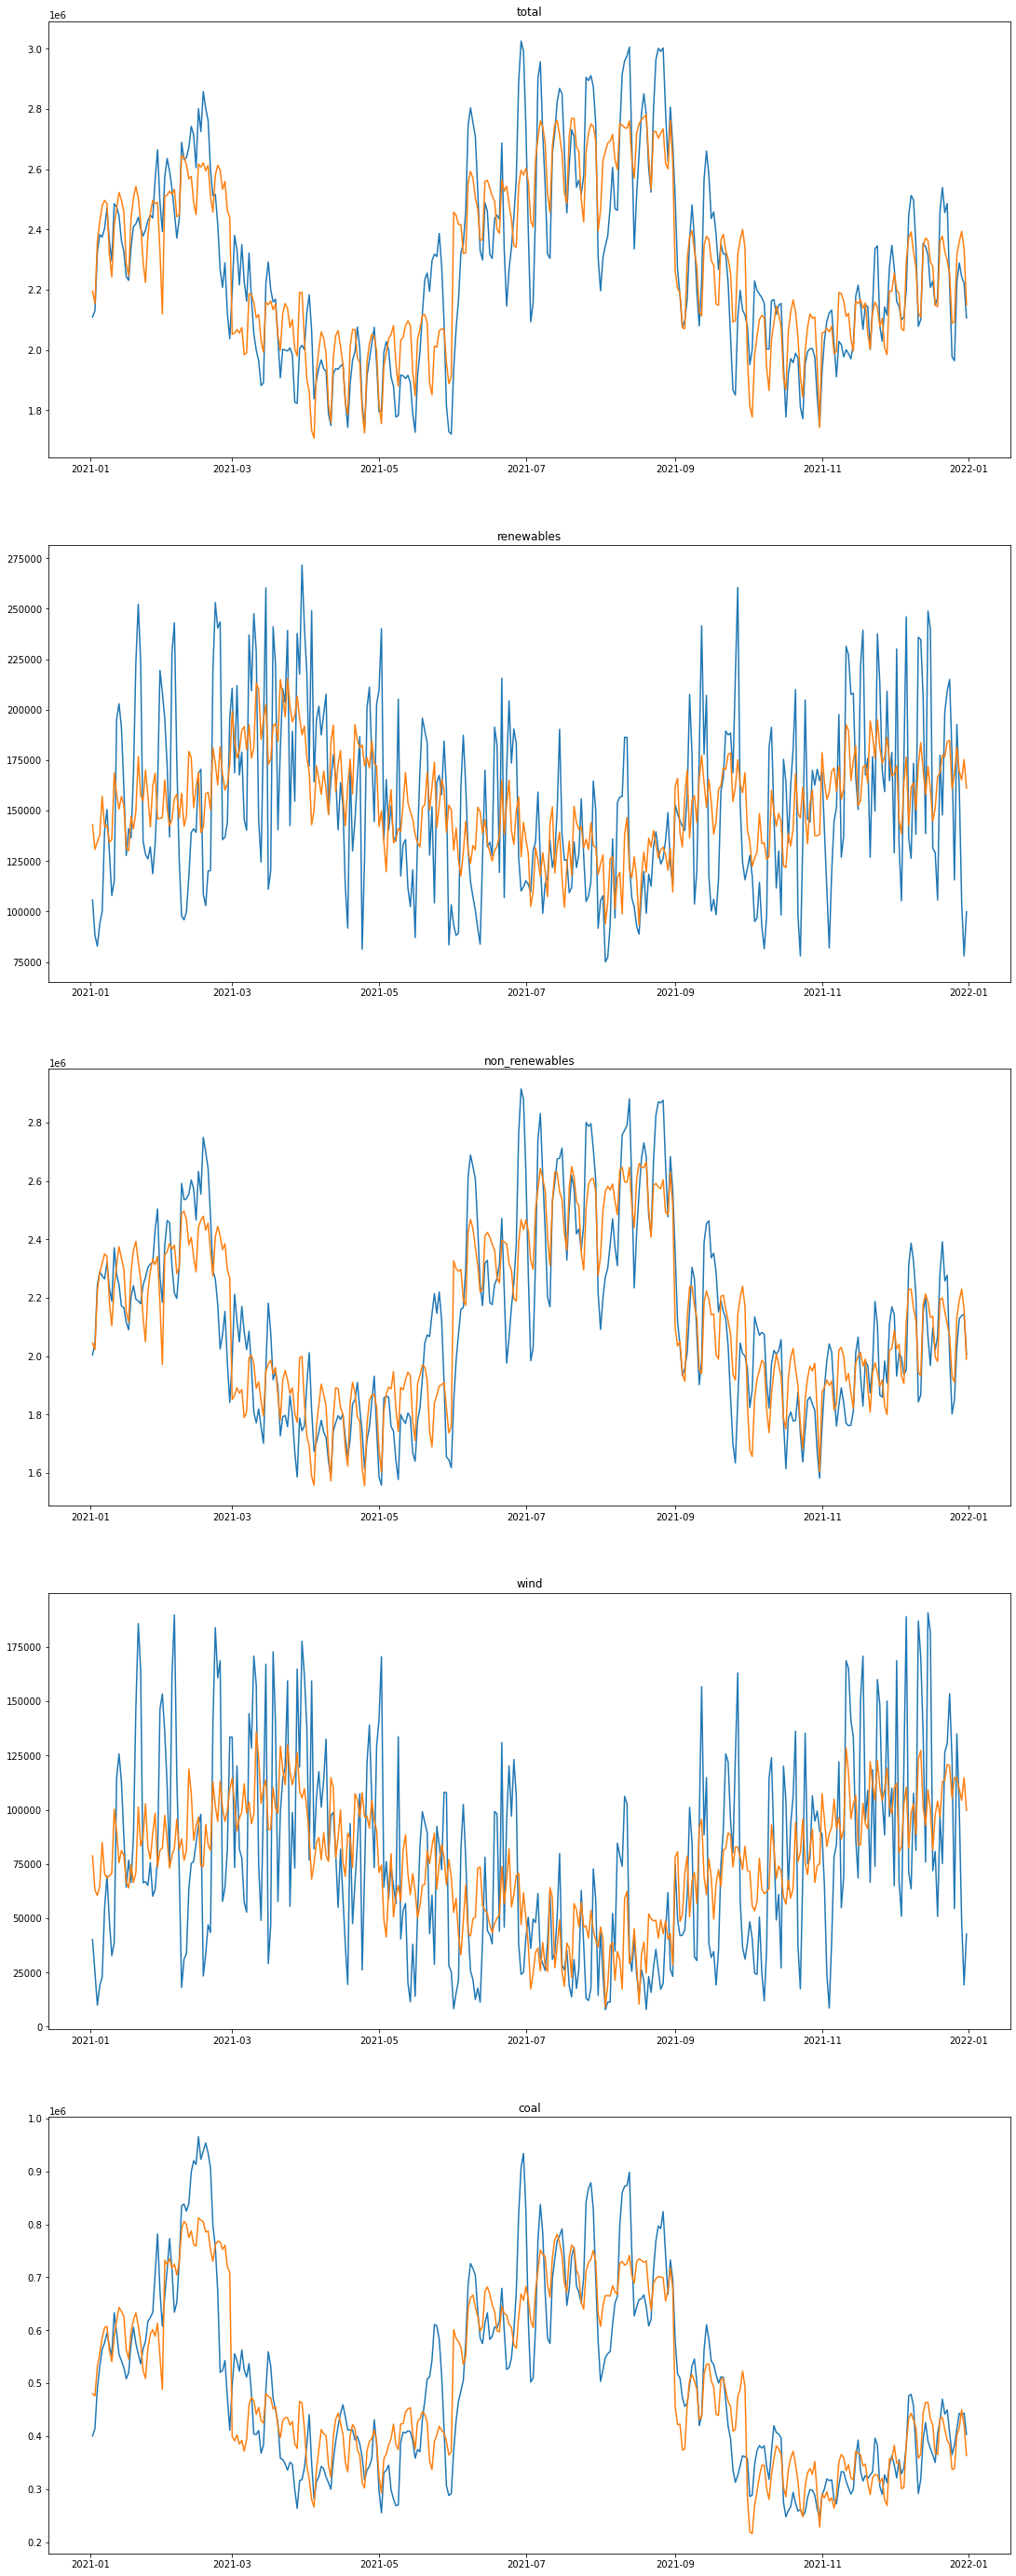

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

power_sources = ['total', 'renewables', 'non_renewables', 'wind', 'coal']
fig, axs = plt.subplots(len(power_sources))
fig.set_size_inches(18.5, 10 * len(power_sources))
for i, power_source in enumerate(power_sources):
    reg = LinearRegression().fit(X_1h, data[power_source])
    y_pred_1h = reg.predict(X_1h)
    print(f'Score for {power_source}: {reg.score(X_1h, np.array(data[power_source]))}')
    axs[i].plot(data['timestamps'], data[power_source])
    axs[i].plot(data['timestamps'], y_pred_1h)
    axs[i].set_title(power_source)


# Gaussian Process using datetime

In [154]:
import GPy
GPy.plotting.change_plotting_library('plotly_offline')

In [211]:
def format_input(series, normalization_const = None):
    series = np.array(series).reshape(-1, 1)
    series_min = np.min(series)
    if not normalization_const:
        normalization_const = np.max(series) - series_min
    return (series - series_min)/normalization_const

def train_gp(x, y):
    input_dims = x.shape[1]
    kernel_rbf = GPy.kern.RBF(input_dim=input_dims, variance=1, lengthscale=1)
    kernel_lin = GPy.kern.Linear(input_dim=input_dims)
    kernel = kernel_lin + kernel_rbf

    m = GPy.models.GPRegression(x, y,kernel)

    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 3)
    return m

In [212]:
x = format_input([ts.timestamp() for ts in data['timestamps']])
y = format_input(data['total'])
m = train_gp(x, y)

Optimization restart 1/3, f = -151.75420464788573
Optimization restart 2/3, f = 50.26500254994909
Optimization restart 3/3, f = 50.26500255085554


In [213]:
def evaluate_model(x, y, m, title='GP prediction vs data'):
    gp_pred = m.predict(x)
    plt.plot(data['timestamps'], y)
    plt.plot(data['timestamps'], gp_pred[0])
    fig = plt.gcf()
    fig.set_size_inches(20, 8)
    fig.suptitle(title)
    plt.show()
    print(f'Loss: {mean_squared_error(y, gp_pred[0])}')

Loss: 0.020592804462130652


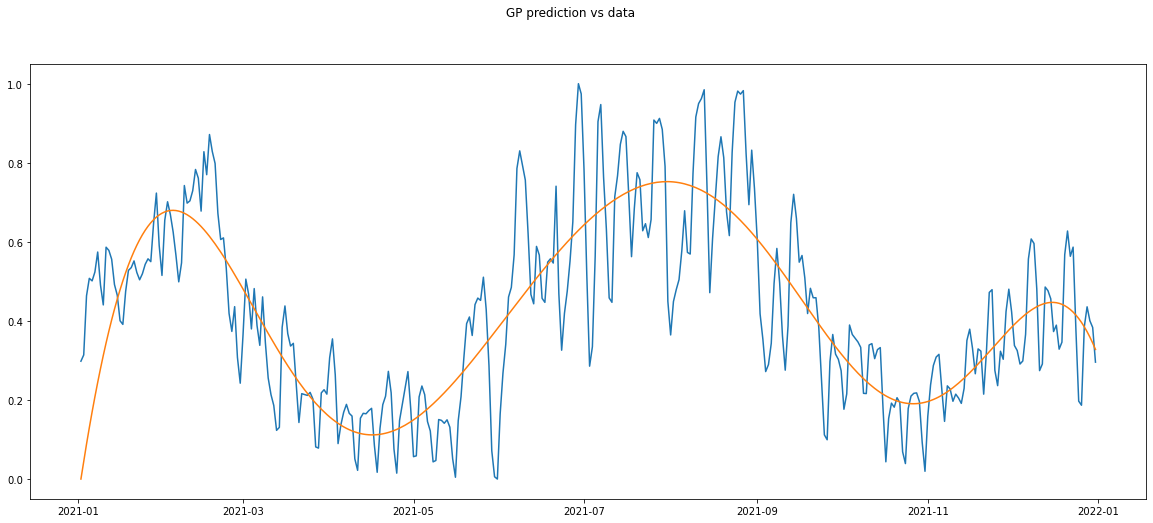

In [165]:
evaluate_model(x, y, m)

# Gaussian Process using decomposed dates

In [221]:
def normalize(arr):
    min = np.min(arr)
    max = np.max(arr)
    return ((np.array(arr, ndmin=2) - min)/(max-min)).T

x = np.concatenate((normalize(day_of_week),
                    normalize(day_of_month),
                    normalize(month)),axis=1)

(364, 3) (364, 1)


Optimization restart 1/3, f = -124.51366587666797
Optimization restart 2/3, f = -124.51366587661028
Optimization restart 3/3, f = -124.5136658765282


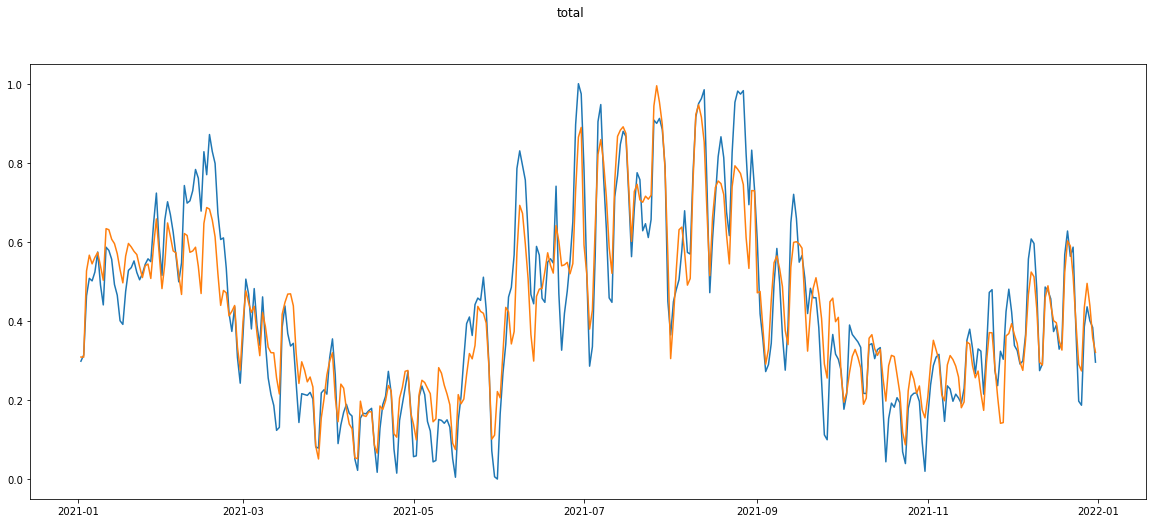

Loss: 0.0069944196853238645
(364, 3) (364, 1)


C:\Users\pedro\anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:

overflow encountered in expm1



Optimization restart 1/3, f = -25.35148325930402
Optimization restart 2/3, f = -37.77792046298674
Optimization restart 3/3, f = -37.77792046269752


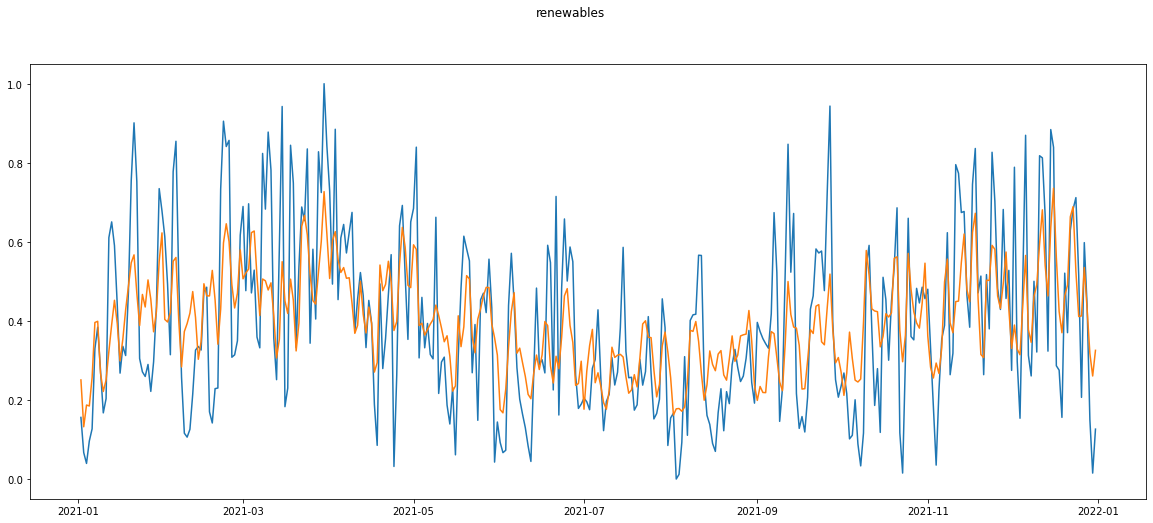

Loss: 0.024780314500293284
(364, 3) (364, 1)


Optimization restart 1/3, f = -127.19570592638286
Optimization restart 2/3, f = -127.19570593198151
Optimization restart 3/3, f = -127.19570593197864


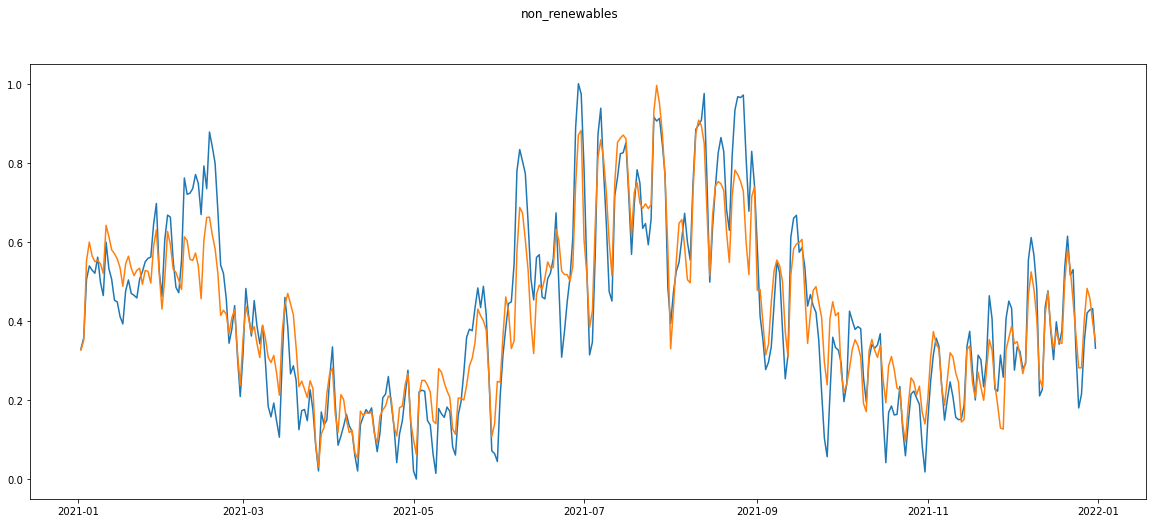

Loss: 0.007042023093045201
(364, 3) (364, 1)


Optimization restart 1/3, f = -20.650566582285535
Optimization restart 2/3, f = -20.65056658103208
Optimization restart 3/3, f = -20.650566582147064


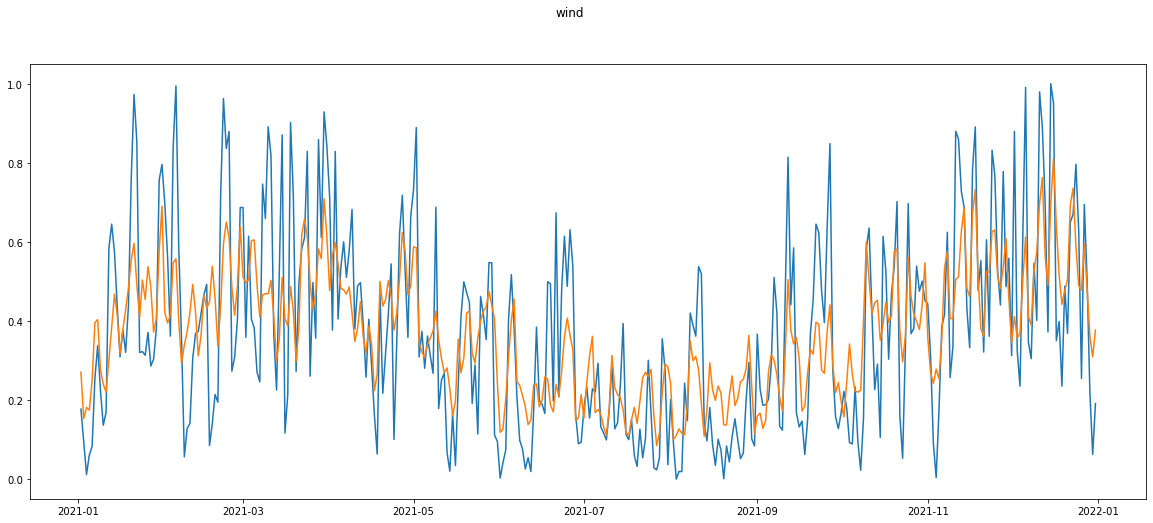

Loss: 0.027003081033601366
(364, 3) (364, 1)


Optimization restart 1/3, f = -16.79471868342489
Optimization restart 2/3, f = -120.15287348420051
Optimization restart 3/3, f = -120.15287348400597


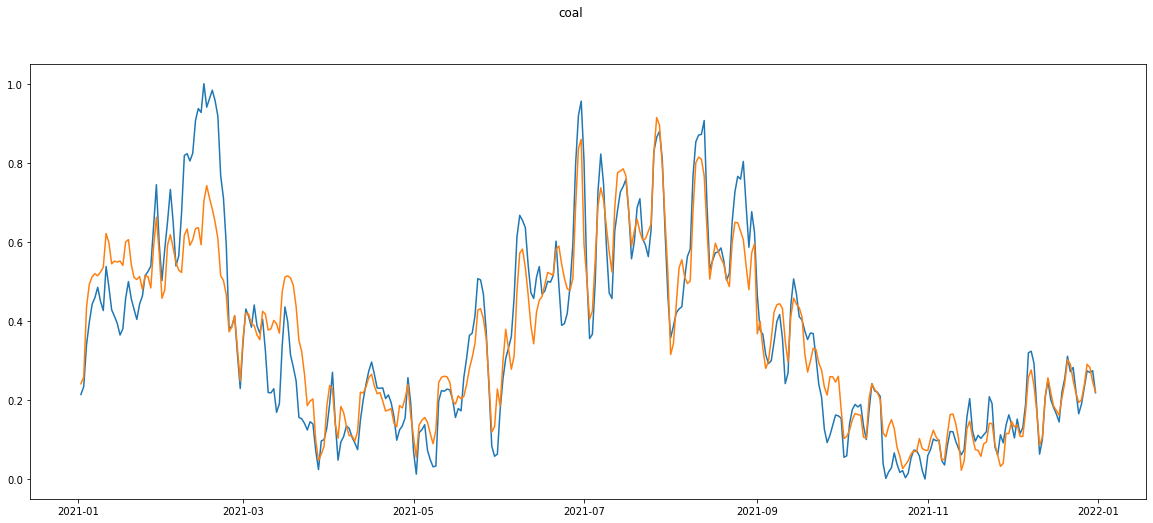

Loss: 0.0075778958965608606


In [222]:
for power_source in power_sources:
    y = format_input(data[power_source])
    print(x.shape, y.shape)
    m = train_gp(x, y)
    evaluate_model(x, y, m, title=power_source)

## Updated Kernel

Optimization restart 1/3, f = -112.99202435405232
Optimization restart 2/3, f = -112.99202439663469
Optimization restart 3/3, f = -112.99202440796702


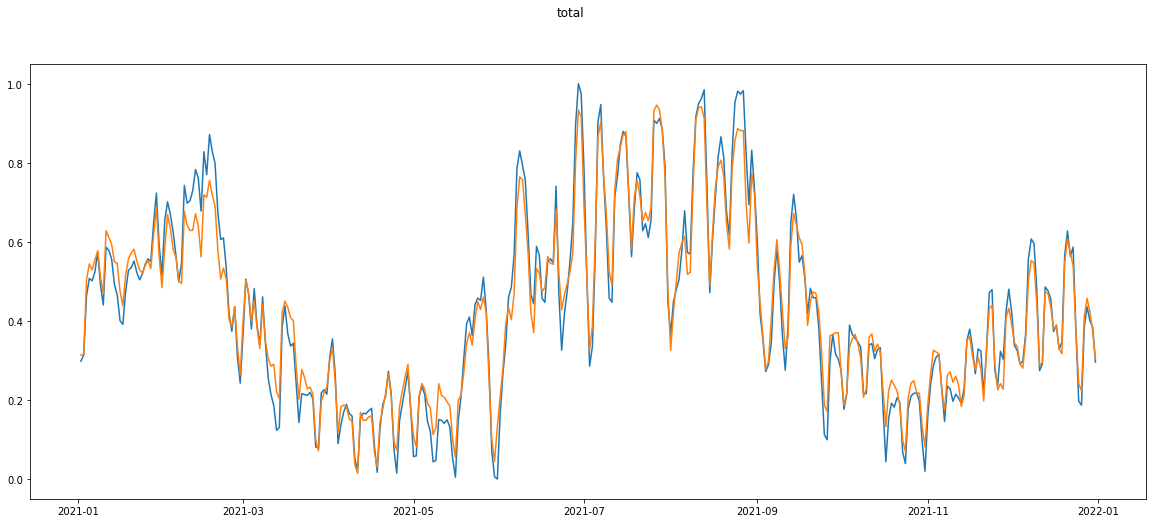

Loss: 0.002080349866770023


Optimization restart 1/3, f = -39.37895981158562
Optimization restart 2/3, f = -39.378959811587265
Optimization restart 3/3, f = -39.378959811506036


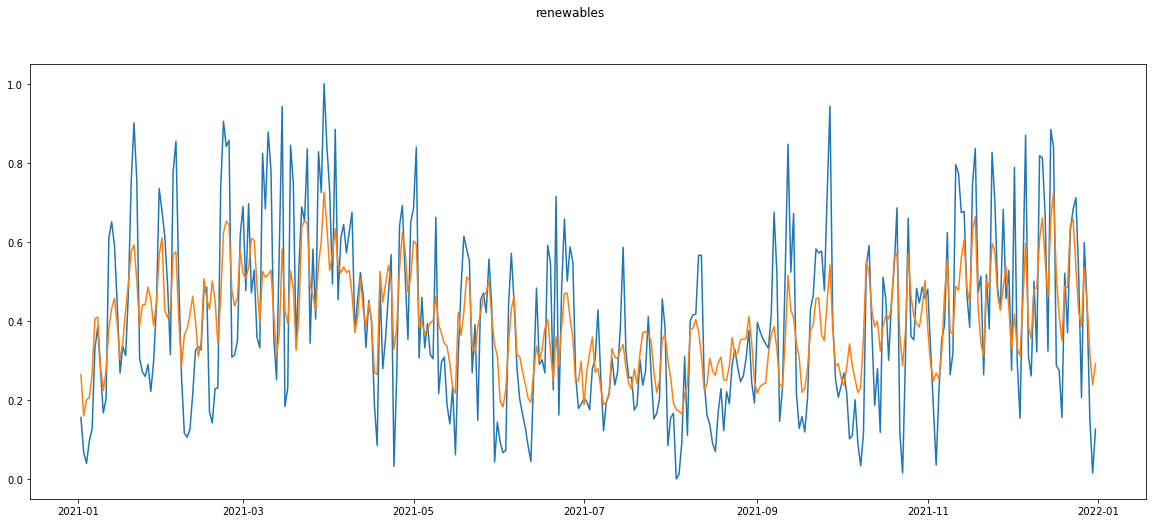

Loss: 0.020890713710532867


Optimization restart 1/3, f = -115.996154177412
Optimization restart 2/3, f = -115.99615417689319
Optimization restart 3/3, f = -115.99615417741191


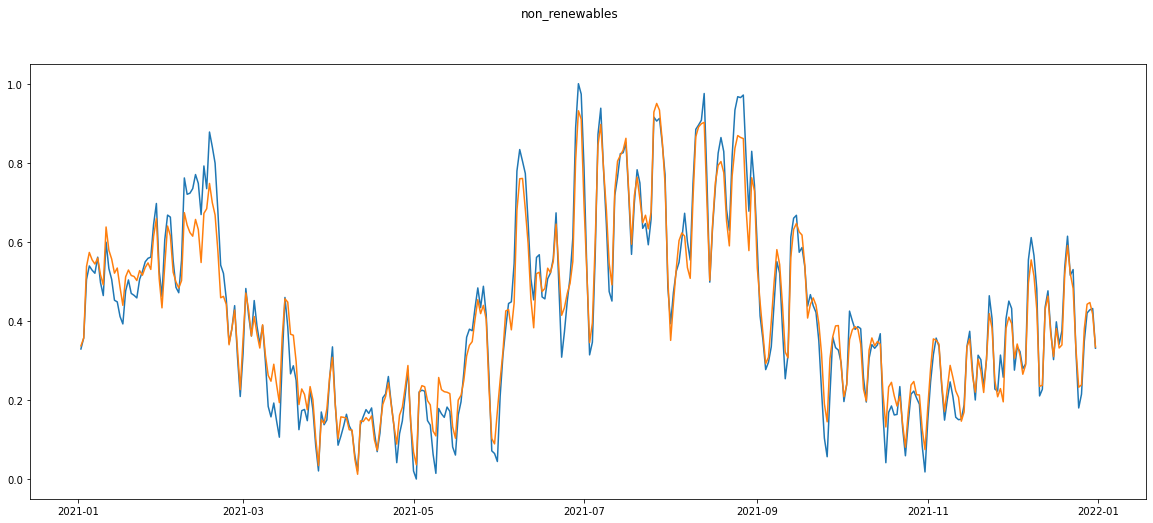

Loss: 0.002233460425495479


Optimization restart 1/3, f = -21.74119754694462
Optimization restart 2/3, f = -21.74119754668436
Optimization restart 3/3, f = -21.7411975469106


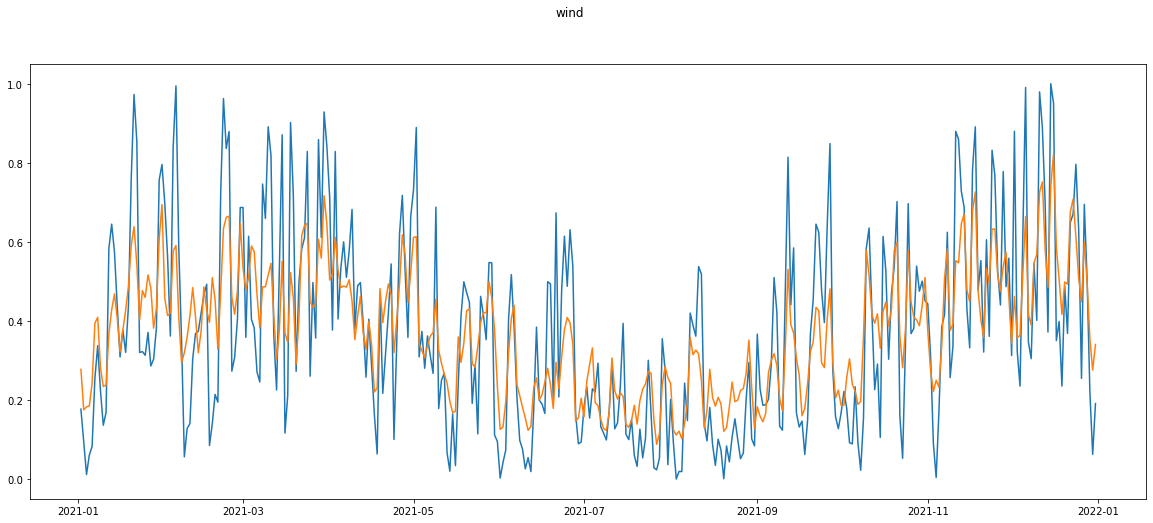

Loss: 0.021218602660950152


Optimization restart 1/3, f = -101.97123544569894
Optimization restart 2/3, f = -101.9712354447808
Optimization restart 3/3, f = -101.971235443171


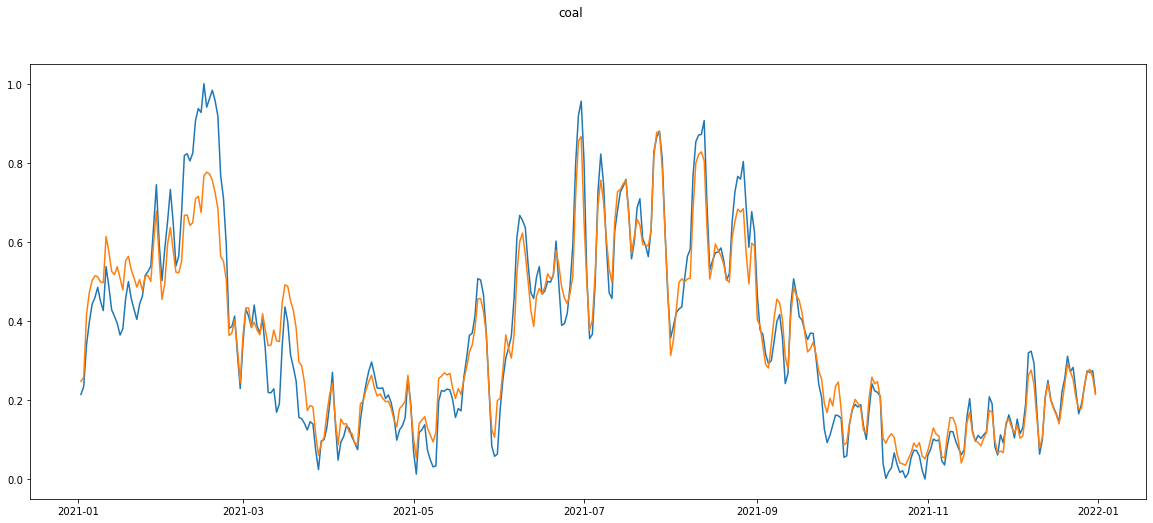

Loss: 0.004286518207833411


In [262]:
def train_gp_v2(x, y):
    input_dims = x.shape[1]
    kernel_rbf = GPy.kern.Matern32(input_dim=input_dims)
    kernel_lin = GPy.kern.Linear(input_dim=input_dims)
    kernel_white = GPy.kern.White(input_dim=input_dims, variance=1)
    kernel = kernel_rbf + kernel_lin + kernel_white

    m = GPy.models.GPRegression(x, y, kernel)

    m.optimize(messages=True)
    m.optimize_restarts(num_restarts = 3)
    return m

Optimization restart 1/3, f = -116.0801344060261
Optimization restart 2/3, f = -116.08013444109764
Optimization restart 3/3, f = -116.08013444146607


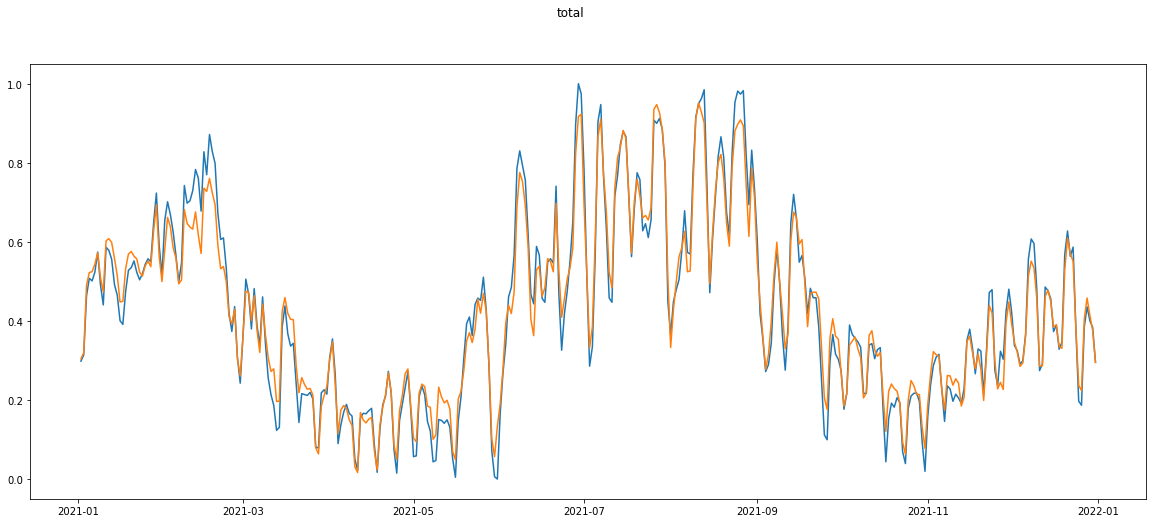

Loss: 0.001778653225903731


Optimization restart 1/3, f = -39.11521349244606
Optimization restart 2/3, f = -39.1152134933572
Optimization restart 3/3, f = -39.11521349281412


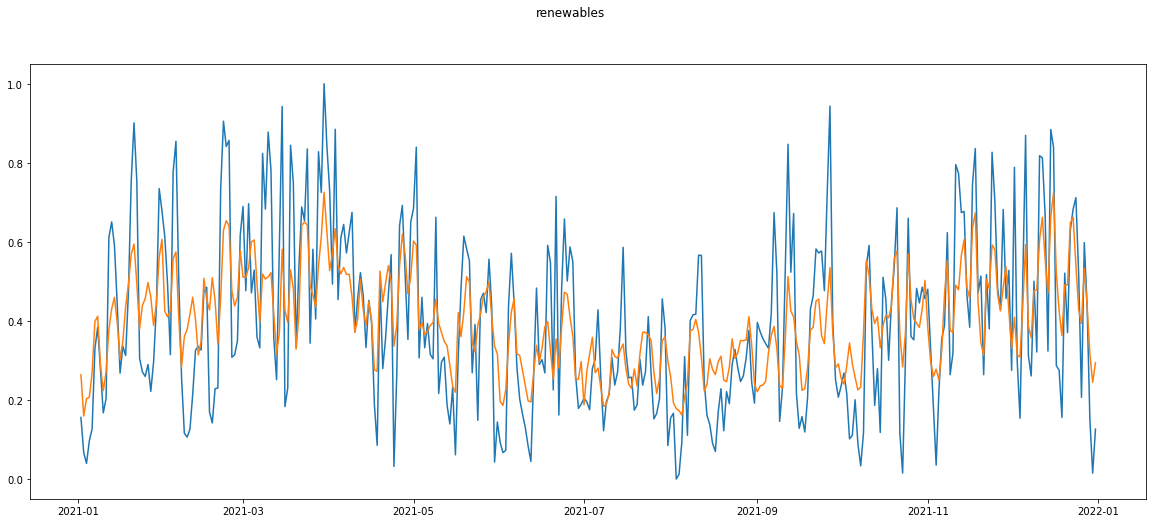

Loss: 0.021253573675184215


Optimization restart 1/3, f = -118.75981522831182
Optimization restart 2/3, f = -118.75981529055099
Optimization restart 3/3, f = -118.75981529058274


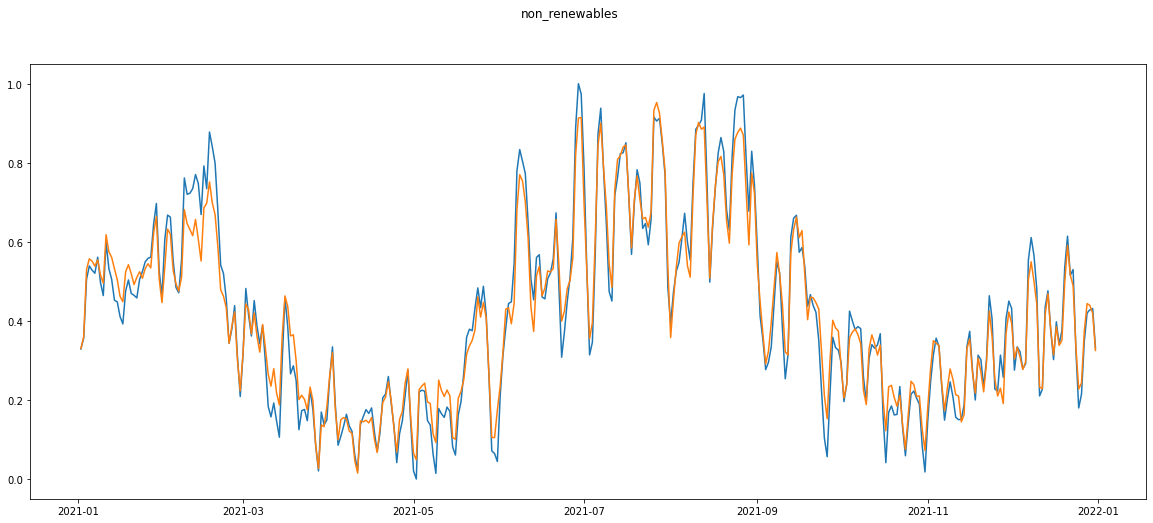

Loss: 0.0020495181307075734


Optimization restart 1/3, f = -21.415169494110557
Optimization restart 2/3, f = -21.41516949412005
Optimization restart 3/3, f = -21.415169494090122


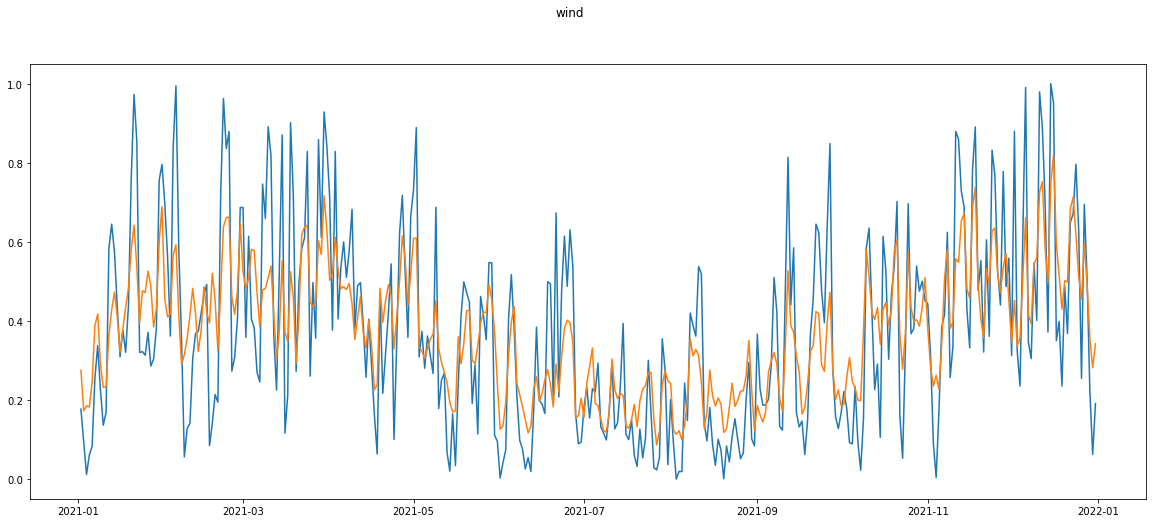

Loss: 0.021613282766300486


Optimization restart 1/3, f = -89.09047008923588
Optimization restart 2/3, f = -103.2950082327755
Optimization restart 3/3, f = -103.29500820369071


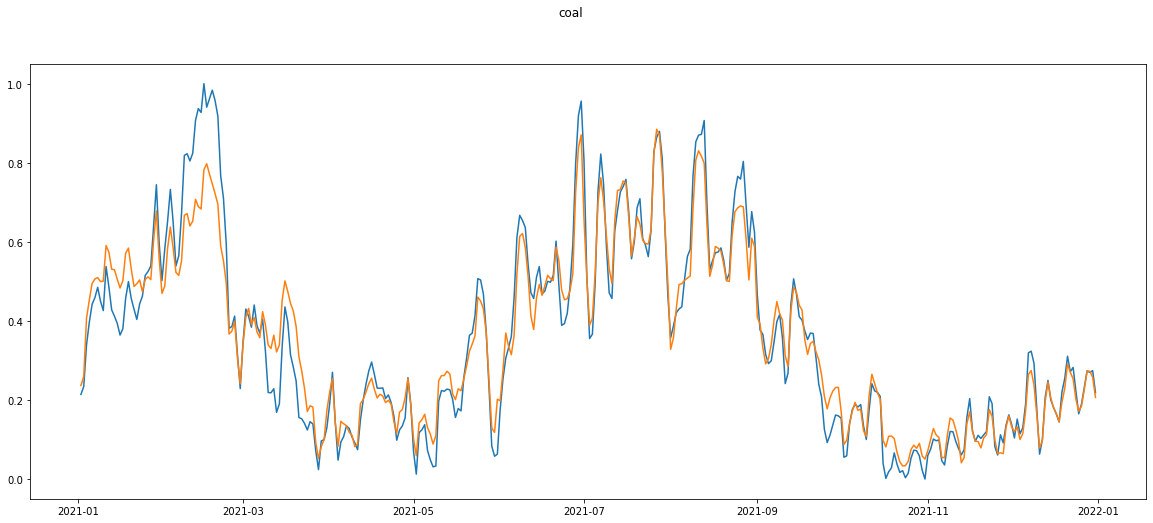

Loss: 0.004103227328743532


In [263]:
x = np.concatenate((normalize(month), normalize(day_of_month), normalize(day_of_week)), axis=1)
x_noisy = x + np.random.normal(0, 0.005, size=x.shape)

for power_source in power_sources:
    y = format_input(data[power_source])
    m = train_gp_v2(x_noisy, y)
    evaluate_model(x, y, m, title=power_source)